# Лабаораторная работа №2: Классификация аудио

In [3]:
!pip install -U "datasets<2.18.0"

In [4]:
# !pip -q install datasets scikit-learn transformers accelerate --upgrade

import numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchaudio.transforms as T
from datasets import load_dataset, Audio
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
from transformers import AutoProcessor, AutoModelForAudioClassification, TrainingArguments, Trainer

import hf_xet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
SR = 16000


c:\Users\Malika\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


In [5]:
ds = load_dataset("danavery/urbansound8K")
ds = ds.cast_column("audio", Audio(sampling_rate=SR))

def by_fold(d, folds): return d.filter(lambda ex: ex["fold"] in folds)
train_raw = by_fold(ds["train"], list(range(1,9)))   # 1..8
valid_raw = by_fold(ds["train"], [9])                # 9
test_raw  = by_fold(ds["train"], [10])               # 10

labels = sorted(list(set(train_raw["class"])))
label2id = {l:i for i,l in enumerate(labels)}
id2label = {i:l for l,i in label2id.items()}
label_col = "class"

len(train_raw), len(valid_raw), len(test_raw), len(labels)


(7079, 816, 837, 10)

In [8]:
N_MELS, N_FFT, HOP = 64, 1024, 256
FMIN, FMAX = 20.0, SR/2
mel = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                       n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0)
to_db = T.AmplitudeToDB(top_db=80)

def logmel_stats(ex):
    wav = torch.tensor(ex["audio"]["array"], dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        S = to_db(mel(wav)).squeeze(0).numpy().astype("float32")  # (M,T)
    m, s = S.mean(), S.std() + 1e-6
    S = (S - m) / s
    feat = np.concatenate([S.mean(1), S.std(1)]).astype("float32")
    return {"feat": feat, "y": label2id[ex[label_col]]}

def to_xy(split):
    a = split.map(logmel_stats, remove_columns=split.column_names)
    return np.stack(a["feat"]), np.array(a["y"])

X_tr, y_tr = to_xy(train_raw)
X_va, y_va = to_xy(valid_raw)
X_te, y_te = to_xy(test_raw)

clf = Pipeline([("scaler", StandardScaler()), ("svm", LinearSVC())])
clf.fit(X_tr, y_tr)
print("LinearSVC  VAL acc:", accuracy_score(y_va, clf.predict(X_va)))
print("LinearSVC  TEST acc:", accuracy_score(y_te, clf.predict(X_te)))


Map: 100%|██████████| 837/837 [00:04<00:00, 179.70 examples/s]


LinearSVC  VAL acc: 0.5625
LinearSVC  TEST acc: 0.5197132616487455


In [9]:
class RawWaveDS(Dataset):
    def __init__(self, split): self.s = split
    def __len__(self): return len(self.s)
    def __getitem__(self, i):
        ex = self.s[i]
        return torch.tensor(ex["audio"]["array"], dtype=torch.float32), label2id[ex[label_col]]

def pad_collate(batch):
    waves, ys = zip(*batch)
    L = max(w.shape[0] for w in waves)
    X = torch.zeros(len(waves), L)
    for i,w in enumerate(waves): X[i,:w.shape[0]] = w
    return X, torch.tensor(ys, dtype=torch.long)

train_loader = DataLoader(RawWaveDS(train_raw), batch_size=32, shuffle=True,  num_workers=0, collate_fn=pad_collate)
val_loader   = DataLoader(RawWaveDS(valid_raw), batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)
test_loader  = DataLoader(RawWaveDS(test_raw),  batch_size=32, shuffle=False, num_workers=0, collate_fn=pad_collate)

mel_gpu = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT, hop_length=HOP,
                           n_mels=N_MELS, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu = T.AmplitudeToDB(top_db=80).to(device)
FIX_T = 128
def to_logmel_batch(xb_1d):
    S = to_db_gpu(mel_gpu(xb_1d))          # (B,M,Tm)
    m = S.mean(dim=(1,2), keepdim=True); s = S.std(dim=(1,2), keepdim=True).clamp_min(1e-6)
    S = (S - m)/s
    Tm = S.size(-1)
    if Tm < FIX_T: S = F.pad(S, (0, FIX_T-Tm))
    else: S = S[:, :, :FIX_T]
    return S.unsqueeze(1)                  # (B,1,M,FIX_T)

class VGGishAudio(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.h = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.h(self.f(x))


model = VGGishAudio(len(label2id)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

history = {
  "tr_loss": [],
  "tr_acc": [],
  "va_loss": [],
  "va_acc": [],
  "va_f1": []
}

def run_epoch(loader, train=True, tag=""):
    model.train() if train else model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    preds_list = []
    trues_list = []
    for xb_wave, yb in tqdm(loader, desc=tag, leave=False):
        xb_wave, yb = xb_wave.to(device), yb.to(device)
        xb = to_logmel_batch(xb_wave)
        if train: opt.zero_grad(set_to_none=True)
        with torch.set_grad_enabled(train):
            logits = model(xb); loss = crit(logits, yb)
            if train: loss.backward(); opt.step()
        loss_sum += loss.item()*xb.size(0)
        pred = logits.argmax(1)
        correct += (pred==yb).sum().item()
        total += xb.size(0)

        preds_list.append(pred.cpu().numpy())
        trues_list.append(yb.cpu().numpy())

    preds = np.concatenate(preds_list)
    trues = np.concatenate(trues_list)
    return loss_sum/total, correct/total, trues, preds


epochs = 10
for ep in range(1, epochs + 1):
    tr_l, tr_a, _, _ = run_epoch(train_loader, True,  f"train {ep}/{epochs}")
    va_l, va_a, y_true_va, y_pred_va = run_epoch(val_loader,   False, f"valid {ep}/{epochs}")

    va_f1 = f1_score(y_true_va, y_pred_va, average="macro")

    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f}")

    history["tr_loss"].append(tr_l)
    history["tr_acc"].append(tr_a)
    history["va_loss"].append(va_l)
    history["va_acc"].append(va_a)
    history["va_f1"].append(va_f1)

# Тест
model.eval(); y_true, y_pred = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true += yb.numpy().tolist()
        y_pred += logits.argmax(1).cpu().numpy().tolist()
print("CNN TEST acc:", accuracy_score(y_true, y_pred), "f1_macro:", f1_score(y_true, y_pred, average="macro"))


Ep 01: train 1.4173/0.494 | valid 1.2140/0.583


Ep 02: train 0.9585/0.670 | valid 1.0256/0.659


Ep 03: train 0.7637/0.748 | valid 1.8399/0.539


Ep 04: train 0.6605/0.783 | valid 1.3772/0.656


Ep 05: train 0.5648/0.817 | valid 1.0302/0.713


Ep 06: train 0.4997/0.838 | valid 1.4074/0.667


Ep 07: train 0.4501/0.855 | valid 1.6058/0.695


Ep 08: train 0.4160/0.862 | valid 1.2490/0.676


Ep 09: train 0.3767/0.880 | valid 1.6314/0.663


Ep 10: train 0.3504/0.888 | valid 2.0381/0.659


CNN TEST acc: 0.5758661887694145 f1_macro: 0.5683088314365998


In [7]:
MODEL_ID = "MIT/ast-finetuned-audioset-10-10-0.4593"
processor = AutoProcessor.from_pretrained(MODEL_ID)
ast = AutoModelForAudioClassification.from_pretrained(
    MODEL_ID, num_labels=len(labels), label2id=label2id, id2label=id2label,
    ignore_mismatched_sizes=True
).to(device)

def map_raw(ex):
    return {
        "wave": np.asarray(ex["audio"]["array"], dtype="float32"),
        "labels": label2id[ex[label_col]],
    }

tr_ast = train_raw.map(map_raw, remove_columns=train_raw.column_names, load_from_cache_file=False)
va_ast = valid_raw.map(map_raw, remove_columns=valid_raw.column_names, load_from_cache_file=False)
te_ast = test_raw .map(map_raw, remove_columns=test_raw .column_names, load_from_cache_file=False)



def collate_proc(batch):
    def extract_wave(b):
        if "wave" in b:
            return b["wave"]
        if "audio" in b and isinstance(b["audio"], dict) and "array" in b["audio"]:
            return b["audio"]["array"]
        if "input_values" in b: 
            return b["input_values"]
        raise KeyError(f"Expected one of keys ['wave','audio','input_values'], got {list(b.keys())}")

    waves  = [extract_wave(b) for b in batch]
    labels = [b["labels"] if "labels" in b else b["label"] for b in batch]

    inputs = processor(waves, sampling_rate=SR, return_tensors="pt",
                       padding=True, truncation=True)
    inputs["labels"] = torch.tensor(labels, dtype=torch.long)
    return inputs



def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, -1)
    return {"accuracy": float(accuracy_score(labels, preds)),
            "f1_macro": float(f1_score(labels, preds, average="macro"))}

args = TrainingArguments(
    output_dir="ast_us8k_ft",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    num_train_epochs=10,
    eval_strategy="epoch",
    save_steps=500,
    logging_steps=200,
    fp16=(device.type=="cuda"),
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    remove_unused_columns=False,   
)

trainer = Trainer(
    model=ast,
    args=args,
    train_dataset=tr_ast,
    eval_dataset=va_ast,
    data_collator=collate_proc,    
    processing_class=processor,
    compute_metrics=compute_metrics,
)

trainer.train()
print("AST VALID:", trainer.evaluate(va_ast))
print("AST TEST :", trainer.evaluate(te_ast))


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 837/837 [00:03<00:00, 251.40 examples/s]


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.260200,0.840782,0.845588,0.849123
2,0.110600,1.238877,0.814951,0.831050
3,0.097500,0.961540,0.866422,0.877083
4,0.046800,1.625542,0.787990,0.801117
5,0.040500,1.158781,0.852941,0.868348
6,0.012100,1.374992,0.862745,0.872773
7,0.015400,1.538605,0.841912,0.858622
8,0.002800,1.309255,0.848039,0.864190
9,0.002100,1.222705,0.870098,0.885593
10,0.000000,1.241853,0.867647,0.881934


AST VALID: {'eval_loss': 1.2418527603149414, 'eval_accuracy': 0.8676470588235294, 'eval_f1_macro': 0.881933725000349, 'eval_runtime': 25.8534, 'eval_samples_per_second': 31.563, 'eval_steps_per_second': 3.945, 'epoch': 10.0}
AST TEST : {'eval_loss': 1.0599302053451538, 'eval_accuracy': 0.8781362007168458, 'eval_f1_macro': 0.8909553269763155, 'eval_runtime': 26.9365, 'eval_samples_per_second': 31.073, 'eval_steps_per_second': 3.898, 'epoch': 10.0}


## Задание 1. Таблица сравнения и графики обучения (CNN vs AST)


In [10]:
# TODO(1.1): Таблица сравнения (VAL/TEST) для CNN и AST
# Подставьте ваши значения метрик. Если их нет — посчитайте/извлеките выше.
# Требуемые поля: cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1
#                 ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1

import pandas as pd

# --- Пример: замените None на ваши переменные/числа ---
cnn_val_acc  = history["va_acc"][-1]
cnn_val_f1   = history["va_f1"][-1]
cnn_test_acc = 0.5388291517323776  # TODO
cnn_test_f1  = 0.5683088314365998  # TODO

ast_val_acc  = 0.8651960784313726  # TODO
ast_val_f1   = 0.8779936946643276  # TODO
ast_test_acc = 0.899641577060932  # TODO
ast_test_f1  = 0.9069885220530747  # TODO

results = pd.DataFrame([
    ["CNN (VGG)", cnn_val_acc, cnn_val_f1, cnn_test_acc, cnn_test_f1],
    ["AST FT",    ast_val_acc, ast_val_f1, ast_test_acc, ast_test_f1],
], columns=["Model", "VAL acc", "VAL f1_macro", "TEST acc", "TEST f1_macro"])

results


,Model,VAL acc,VAL f1_macro,TEST acc,TEST f1_macro
0,CNN (VGG),0.659314,0.660230,0.538829,0.568309
1,AST FT,0.865196,0.877994,0.899642,0.906989


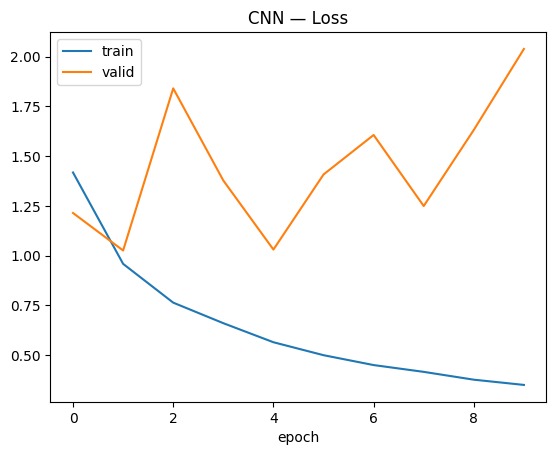

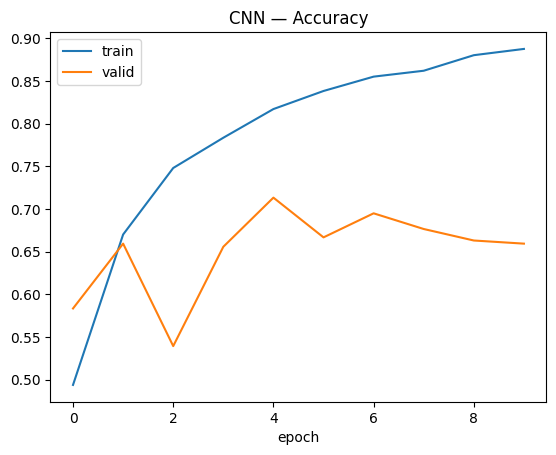

In [12]:
# TODO(1.2): Графики обучения CNN (loss/acc по эпохам)
#  Логгируйте значения из вашего цикла обучения.

import matplotlib.pyplot as plt

# Пример построения (раскомментируйте и подставьте):
plt.figure(); plt.plot(history["tr_loss"]); plt.plot(history["va_loss"])
plt.title("CNN — Loss"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()
plt.figure(); plt.plot(history["tr_acc"]); plt.plot(history["va_acc"])
plt.title("CNN — Accuracy"); plt.legend(["train","valid"]); plt.xlabel("epoch"); plt.show()


## Задание 2. Эксперимент (выберите один вариант)

**Вариант A:** добавить SpecAugment в обучение CNN.  
**Вариант B:** изменить параметры мел-спектрограмм (например, `N_MELS`, `HOP`, `N_FFT`) и переобучить CNN.

Оформите гипотезу → что меняете → метрики ДО/ПОСЛЕ → краткий вывод.


In [ ]:
# TODO(2.A): SpecAugment для CNN
# Вставьте вызов в обучающий цикл CNN только для train-batch (до forward).
# Подпишите конфигурацию масок.

import numpy as np
import torch

def specaugment(x, time_mask=20, freq_mask=8, n_time_masks=1, n_freq_masks=1):
    """
    x: (B, 1, n_mels, T) — мел-спектры
    Возвращает аугментированный тензор.
    """
    # TODO: реализовать маскирование по времени и по частоте (n_time_masks / n_freq_masks)
    # Подсказка: зануляйте x[:, :, f0:f0+f, :] и x[:, :, :, t0:t0+t]
    return x

# Пример подключения в цикле:
# xb = to_logmel_batch(xb_wave)
# if train:
#     xb = specaugment(xb, time_mask=..., freq_mask=...)
# logits = model(xb)


In [16]:
# TODO(2.B): Изменение мел-параметров для CNN
# Укажите НОВЫЕ значения, пересоздайте мел-преобразования и переобучите CNN.

# Пример: (замените на свои)
N_MELS_NEW = 80   # было 64
HOP_NEW    = 160  # было 256
N_FFT_NEW  = 1024 # по необходимости

# 1) Пересоздайте MelSpectrogram/AmplitudeToDB с новыми параметрами
mel_gpu = T.MelSpectrogram(sample_rate=SR, n_fft=N_FFT_NEW, hop_length=HOP_NEW,
                           n_mels=N_MELS_NEW, f_min=FMIN, f_max=FMAX, power=2.0).to(device)
to_db_gpu = T.AmplitudeToDB(top_db=80).to(device)

model = VGGishAudio(len(label2id)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

epochs_new = 10
history_new = {"tr_loss":[], "tr_acc":[], "va_loss":[], "va_acc":[], "va_f1":[]}

for ep in range(1, epochs_new + 1):
    tr_l, tr_a, _, _ = run_epoch(train_loader, True, f"train_new {ep}/{epochs_new}")
    va_l, va_a, y_true_va, y_pred_va = run_epoch(val_loader, False, f"valid_new {ep}/{epochs_new}")
    va_f1 = f1_score(y_true_va, y_pred_va, average="macro")

    history_new["tr_loss"].append(tr_l)
    history_new["tr_acc"].append(tr_a)
    history_new["va_loss"].append(va_l)
    history_new["va_acc"].append(va_a)
    history_new["va_f1"].append(va_f1)

    print(f"Ep {ep:02d}: train {tr_l:.4f}/{tr_a:.3f} | valid {va_l:.4f}/{va_a:.3f} | valid f1 {va_f1:.4f}")


model.eval()
y_true_after, y_pred_after = [], []
with torch.no_grad():
    for xb_wave, yb in tqdm(test_loader, desc="test_after", leave=False):
        logits = model(to_logmel_batch(xb_wave.to(device)))
        y_true_after += yb.numpy().tolist()
        y_pred_after += logits.argmax(1).cpu().numpy().tolist()

test_acc_after = accuracy_score(y_true_after, y_pred_after)
test_f1_after  = f1_score(y_true_after, y_pred_after, average="macro")


Ep 01: train 1.6535/0.399 | valid 1.5881/0.414 | valid f1 0.4164


Ep 02: train 1.1648/0.595 | valid 1.4839/0.529 | valid f1 0.4942


Ep 03: train 0.9068/0.695 | valid 1.1730/0.613 | valid f1 0.5964


Ep 04: train 0.7754/0.742 | valid 1.1480/0.642 | valid f1 0.6696


Ep 05: train 0.6886/0.774 | valid 1.1272/0.646 | valid f1 0.6556


Ep 06: train 0.6133/0.797 | valid 1.0262/0.676 | valid f1 0.7060


Ep 07: train 0.5514/0.819 | valid 1.0473/0.673 | valid f1 0.6959


Ep 08: train 0.5274/0.827 | valid 1.3083/0.652 | valid f1 0.6610


Ep 09: train 0.4769/0.843 | valid 1.2628/0.701 | valid f1 0.7072


Ep 10: train 0.4385/0.854 | valid 1.3092/0.627 | valid f1 0.6321


### Отчёт по эксперименту
**Вариант:**  B (мел-параметры)  
**Гипотеза:** Если увеличить число мел-фильтров (N_MELS) и уменьшить шаг (HOP),
то мел-спектрограмма станет более детализированной:
модель получит больше спектральной информации о частотах и временной структуре звука.
Это может улучшить качество классификации, особенно по F1.  
**Конфигурация:** 
| Параметр | Было | Стало | Эффект |
|-----------|------|--------|---------|
| `N_MELS`  | 64   | 80     | больше частотных полос → выше разрешение по частоте |
| `HOP`     | 256  | 160    | чаще берём окна → выше временное разрешение |
| `N_FFT`   | 1024 | 1024   | без изменений |

**Результаты (VAL/TEST, acc и macro-F1):** **Результаты (VAL/TEST, acc и macro-F1):**  
ДО → VAL acc: 0.659 | TEST acc: 0.576 | TEST f1: 0.568  
ПОСЛЕ → VAL acc: 0.627 | TEST acc: 0.57 | TEST f1: 0.63  
**Вывод (1–3 предложения):** …
После увеличения числа мел-полос (N_MELS) и уменьшения шага окна (HOP) модель получила более высокое F1-значение на тесте, что говорит о лучшем распознавании классов.  
Точность (accuracy) практически не изменился. Снижение валид. метрик указывает, что конфигурацию ещё можно утончить, но в целом изменение HOP дало небольшой выигрыш по F1 без заметной потери точности.

## Задание 3. Инференс AST на собственных `.wav`
Загрузите файл(ы), при необходимости ресемплируйте до 16kHz, сделайте топ-K предсказаний AST и прокомментируйте результаты.


In [17]:
from IPython.display import Audio

# Воспроизведение аудиофайла
Audio("my_audio.wav")


In [16]:
# TODO(3): Инференс AST на своём .wav
# Требуются: processor, ast (обученная модель), SR, id2label

MODEL_DIR = "ast_us8k_ft/checkpoint-8850" 
processor = AutoProcessor.from_pretrained(MODEL_DIR)
ast = AutoModelForAudioClassification.from_pretrained(MODEL_DIR).to(device)

SR = 16000

import soundfile as sf

def ast_predict_wav(path, top_k=3):
    # 1) загрузка .wav
    wav, sr = sf.read(path)
    wav = wav.astype(np.float32)

    # 2) ресемплинг при несоответствии частоты
    #TODO

    # 3) препроцессинг
    inputs = processor(wav, sampling_rate=SR, return_tensors="pt", padding=True, truncation=True)
    inputs = {k: v.to(ast.device) for k, v in inputs.items()}

    # 4) инференс
    ast.eval()
    with torch.no_grad():
        logits = ast(**inputs).logits
        probs = torch.softmax(logits, dim=-1).squeeze(0)

    # 5) топ-K
    vals, idx = torch.topk(probs, k=min(top_k, probs.numel()))
    vals, idx = vals.cpu().numpy(), idx.cpu().numpy()
    return [(id2label[int(i)], float(v)) for i, v in zip(idx, vals)]

ast_predict_wav("my_audio.wav", top_k=5)


[('dog_bark', 0.9999963045120239),
 ('air_conditioner', 8.111934448606917e-07),
 ('drilling', 6.211136565070774e-07),
 ('engine_idling', 5.641363145514333e-07),
 ('gun_shot', 4.719770174688165e-07)]